# Chapter 4. Training Models

- In many situations, you need to understand the implementation of many algorithms.
- But understanding the underlying logic of machine learning algorithms will help you to:
    - Pick the right one for the task
    - Pick a good initial set of hyper-parameters
    - Pick a good training algorithm
    - ...
- lastly, most of the topics discussed in this chapter will be essential for understanding neural networks.
- In this chapter, we will start by lookin at linear regression training from two different angles:
    - Using a direct "closed-form" analytical method to get the optimal parameters for the linear model
    - Using an interative optimization method called gradient descent.
        - It gradually tweaks the model parameters until it converges to the same set of parameters found by method 1.
        - we will take a look at multiple types of gradient descent: stochastic GD, batch GD, Mini-batch GD.
- Next we will look at polynomial regression, or models that can fit non-linear datasets.
- Then we will look at several regularization techniques that will help up reduce the overfitting typically found in Polynomial models.
- Finally, we will look at two popular models used for classification tasks: Logistic regression & softmax regression.

## Linear Regression

- In chapter I, we looked at a simple model for *Life Satisfaction*:
$$life\_satisfaction = \theta_{0} + \theta_{1} \times GDP\_per\_capita$$
- This model is just a linear function of `GDP_per_Capita` with $\theta_{0}$ and $\theta_{1}$ as parameters.
- A linear model makes a prediction by simply computing the weighted sum of the input features + a constant called a bias term.
- More generally:
$$\hat{y} = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \dots + \theta_{n}x_{n}$$
- This can be written much more consicely using its vectorized form:
$$
\hat{y}=h_{\theta}(x)=\theta \cdot x \space | \space
\theta=\begin{bmatrix} \theta_{0}  \\ \theta_{1}  \\ \vdots  \\ \theta_{n} \end{bmatrix},
x=\begin{bmatrix} 1 \\ x_{1} \\ \vdots \\ x_{n} \end{bmatrix}
$$
- *Note:* $\cdot$ in $\theta \cdot x$ represent the dot product & not vector multiplication.
- $h_{\theta}(x)$ is the hypothesis function using parameters $\theta$.
- Note
    - In ML, vectors are often represented as column vectors.
    - Because $\theta$ and $x$ are both column vectors, we can write the prediction as follows:
$$\hat{y} = \theta^{T} x$$
        - Now, $\hat{y}$ is a single-cell matrix resulting from matrix multiplication.
    - In this book, we will use this notation to avoid switching between dot products and matrix multiplications.
- Training a model means adjusting its parameters so it best fits the data.
- For us to succeed, we first need to describe what do we mean by "best fitting the data". 
- We pick the mean sqaured error ($MSE$) as measure of the model performance:
$$MSE(X,h_{\theta}) = \frac{1}{m} \sum_{i=1}^{m} (\theta^{T}x^{(i)} - y^{(i)})^2$$
- Where $X$ is the training data set represented as $X=\{(x_{1},y_{1}), (x_{2},y_{2}), \dots, (x_{m},y_{m})\}$

### The Normal Equation
- To find $\theta$ that minimizes the cost/loss function $MSE(\theta)$, there is a closed form solution.
- In other words, a mathematical equation that gives the result directly, and it's called the normal equation.
$$\hat{\theta}=(X^{T}X)^{-1}X^{T}y$$
- $\hat{\theta}$ is the value of $\theta$ that minimizes the cost function $MSE(\theta)$.
- Let's generate some linear data to test this equation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

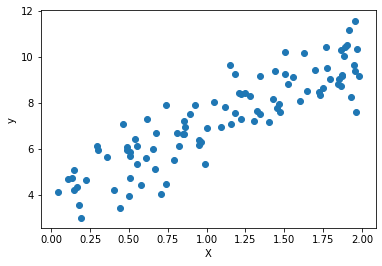

In [3]:
plt.scatter(x=X, y=y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

- Now let's compute $\hat{\theta}$ using the normal equation:

In [4]:
X_b = np.c_[np.ones_like(X), X]

In [5]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.9987675 ],
       [3.00316623]])

- The parameters that we used to generate the data (with some noise) are $\theta_{0}=4$ and $\theta_{1}=3$.
- The noise was responsible for not making it possible to recover the initial parameters $\theta_{0}$ & $\theta_{1}$.
- Now we can make predictions using our optimal parameters:

In [6]:
X_ = np.array([[0], [2]])
X_ = np.c_[np.ones_like(X_), X_].T
X_.shape

(2, 2)

In [7]:
y_hat = np.matmul(theta_best.T, X_)

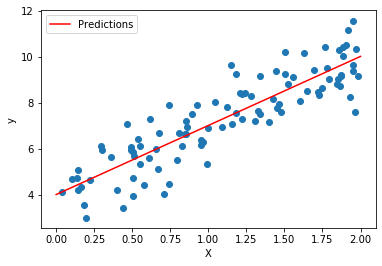

In [8]:
plt.scatter(x=X, y=y)
plt.plot([0,2], y_hat.flatten(), color='red', label='Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

- Performing Linear Regression using scikit-learn is also simple:

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
lin_reg = LinearRegression(n_jobs=-1)

In [11]:
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [12]:
lin_reg.intercept_, lin_reg.coef_

(array([3.9987675]), array([[3.00316623]]))

In [13]:
lin_reg.predict(np.array([[0],[2]]))

array([[ 3.9987675 ],
       [10.00509996]])

- The `LinearRegression` class is based on `scipy.linalg.lstsq` function which you could call directly:

In [14]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

In [15]:
theta_best_svd

array([[3.9987675 ],
       [3.00316623]])

- The function computes $\hat{\theta}=X^{+}y$ where $X^{+}$ is the Moore-Penrose inverse, $X^{+}=(X^{T}X)^{-1}X^{T}$.
    - You can compute it directly:

In [16]:
np.linalg.pinv(X_b).dot(y)

array([[3.9987675 ],
       [3.00316623]])

- The pseudoinverse itself is computed using a **standard matrix vectorization** technique called **Singular Value Decomposition** (SVD).
    - SVD can decompose the training set $X$ into the matrix multiplication of 3 matrices: $U \space \Sigma \space V^{T}$.
    - As a result, we have $X^{+}=V \Sigma^{+} U^{T}$
    - To compute the matrix $\Sigma^{+}$, the algorithm takes $\Sigma$ and:
        - Sets to zero all values smaller than an $\epsilon$
        - Replaces all the non-zero values with their inverse
        - Finally transposes the resulting matrix.
- This approach is more efficient than directly computing the normal equation
    - It handles edge cases nicely.
- The nomral equation may not work if $X^{T}X$ is not invertible but the pseudoinverse is always defined.

### Computational Complexity

- The normal equation computes the inverse of $X^{T}X$, which is an $(n+1) \times (n+1)$ matrix (where n is the number of features).
- The computation complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^{3})$, depending on the implementation.
- In other words, **if you double the number of features, you will increase the computation time by x5.3 to x8.**
- Notes
    - Both the normal equation & SVD approaches get very slow with a large number of features (100,000).
    - On a positive side, both are linear when it comes to the number of instances (or observations) you have in $X$.
- Once you trained your model using the Normal equation or SVD, predictions are exported really fast.
     - Linear complexity on both instances and features.
- Now we will look at a completely different way of finding the optimal parameters $\theta$
    - **It is suitable when you have too many features or instances you can't fit in memory**:

## Gradient Descent

- Gradient Descent is a generic optimization algorithm capable of finding solutions to a wide veriety of problems.
- The general idea of gradient descent is to tweak a model's parameters iteratively until we converge to an optimal set of parameters $\hat{\theta}$.
- Suppose you are lost in the mountain with dense fog, you can't see anything, you only can feel the ground below your feet. and you want to go home.
    - A good strategy is to move in the direction of the steepest slope.
    - This is exactly what gradient descent does.
- GD measures the local gradient of the error function with regards to the parameter function $\theta$ and goes in the direction of descending gradient.
- **Once the gradient is Zero, you have reached a minimum**.
- Practically, you start by initializing $\theta$ with random values (this is called **random initialization**).
- Then you improve it gradually, taking one baby step at a time.
    - Each step attempting to decrease the cost function, until you converge to a minimum:
    
<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/GD.png"></div>

- An important parameter in gradient descent is the size of the step, determined by the *learning rate* hyper-parameter.
    - If the learning rate is too small, the algorithm will take a long time to convert to a minimum.
    - If the learning rate is too big, the algorithm my jump infinately between intervals or even diverge.
- Finally, not all cost functions look like nice, regular bowls.
    - there may be holes/ridges/plateaus and all sorts of irregular terrains.
- The curvatures of most cost functions is challenging.
- As a result, the initialization of your parameters play an important role, depending on where did you start, you might end up in a place or another:

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/Loss_curvature.png"></div>

- Fortunately, $MSE$ for Linear regression is a convex function, meaning, It's garanteed that the found minimum is th global minimum of the function.
    - No local minima, just one **global minimum**
- It's also a continuous function with a slope that never changes ubruptly (Lipschitz continuious).
- The Cost function has a shape of a bowl
    - But it can be an elongated bowl without feature scaling (because the dynamic range of each feature's parameter will be different):

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/scaling_effect.png"></div>

- By not doing feature scaling and by enforcing a constant learning rate for both feature parameters, the algorithm will take longer to reach the global minimum.
- Warning: When using gradient descent, make sure that all features are scaled.
- Briefly, when we are training the model, we are effectively **searching** for a parameter set that minimizes the cost function.
    - **It's a search in the model's parameter space**
        - The more parameters the model has, the more dimensions the space has, the harder for us to find the optimal set of parameters.

### Batch Gradient Descent

- To implement Gradient Descent, you need to compute the gradient of the cost function with regards to each model parameter $\theta_{j}$.
    - This is called a partial derivative.
- Let's compute the partial derivative of our previously defined cost function $MSE$:

$$\frac{\partial{J}}{\partial{\theta_{j}}}(\theta)=\frac{2}{m}\sum_{i=1}^{m}(\theta^{T}x^{(i)}-y^{(i)})x_{j}^{(i)}$$

- instead of computing the partial derivatives individually, we can give a general expression for batch mean squared error gradient:
- We have:
$$MSE(\theta)=\frac{1}{m}(X\theta - y)^2$$
- So:
$$\nabla_{\theta}MSE(\theta)=\frac{2}{m}X\cdot(X\theta-y)$$
- & because we prefer matrix multiplication over the dot product notation:
$$\nabla_{\theta}MSE(\theta)=\frac{2}{m}X^{T}(X\theta-y)$$
- Because, for two vectors $w$ and $x$:
$$w \cdot x = w^{T}x$$
- Notice that this formula involves calculating the gradient over the whole training set ($X$) for every learning step.
    - This is why this algorithm is called `Batch Gradient Descent`, the batch represending teh whole training set.
    - As a result, It's very slow on large training sets.
    - However, GD scales well with the number of features.
- Once you have the gradient vector, which points uphill, go in the opposite direction to go downhill.
- The gradient descent algorithm:
$$\theta^{\space(next \space step)} = \theta - \eta \nabla_{\theta}MSE(\theta)$$
- Let's look at a quick implementation of this algorithm:

- Data Preparation:

In [32]:
X = np.linspace(start=0, stop=1, num=100)
y = (0.5 * X) + 0.1 + 0.3 * np.random.rand(100)

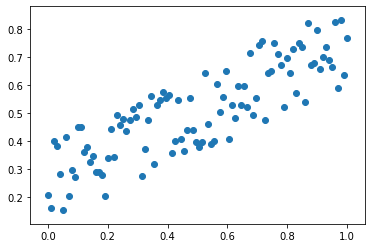

In [33]:
plt.scatter(x=X, y=y)
plt.show()

Next, we append `1`s to X:

In [36]:
X = np.c_[np.ones_like(X), X]

We then randomly initialize the parameters:

In [38]:
theta = np.random.rand(2)

In [48]:
def mse(X, y, theta):
    """Returns the Mean Squared Error.
    
    # Arguments:
        X, np.ndarray: the intput training data with `1`s appended to each row.
        y, np.ndarray: the targets of the training rows.
        theta, np.ndarray: the parameter vector of the model.
    
    # Returns
        MSE, float: Mean Squared Error between `X*theta` and `y`.
    """
    m = X.shape[0]
    X_theta = np.matmul(X, theta)
    return 1./m * np.matmul((X_theta - y).T, (X_theta - y))

In [52]:
def grad_mse(X, y, theta):
    """Returns MSE's Gradient Vector.
    
    # Arguments
        X, np.ndarray: the intput training data with `1`s appended to each row.
        y, np.ndarray: the targets of the training rows.
        theta, np.ndarray: the parameter vector of the model.
    
    # Results
        grad_mse, np.ndarray: the gradient vector of the mean squared error function. 
    """
    m = X.shape[0]
    X_theta = np.matmul(X, theta)
    return 2./m * np.matmul(X.T, X_theta - y)

Let's choose a learning rate:

In [56]:
lr = 0.01

Now let's optimize our model parameters, $\theta_{0}$ and $\theta_{1}$:

In [63]:
while mse(X, y, theta) > 0.01:
    theta = theta - lr * grad_mse(X, y, theta)

In [64]:
mse(X, y, theta)

0.00805677595278975

Let's check our parameters:

In [65]:
theta

array([0.27674029, 0.46500651])

Finally, let's check what our model learned:

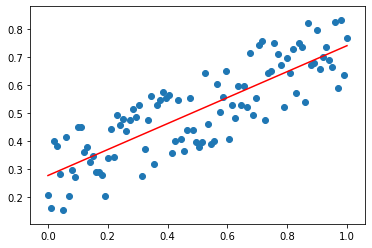

In [74]:
plt.scatter(x=X[:,1], y=y)
plt.plot([0,1], [theta[0] + theta[1]*0, theta[0] + theta[1]*1], color='red')
plt.show()

- Batch Gradient Descent worked perfectly.
- What if you had used a different learning rate $\eta$?
- The following figure shows the first 10 steps of gradient descent using different learning rates (the dashed line represents the initial one):

<div style="text-align:center;"><img style="width: 66%;" src="static/imgs/different_lrs.png"></div>

- On the left the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time.
- In the middle, the learning rate looks pretty good: in just a few iterations, it had already converged to a solution.
- On the right, the learning rate is too high, the algorithm diverges, jumping all over the place and actually getting away from the solution.
- To find a good learning rate, you may want to try grid/random search
    - use just a few iterations to get an idea of a good learning rate without spending a lot of resources (compute or time)
- You may wonder how to find a good iterations number
    - If you set it low, you'll miss on a better trained model and consequently, better results.
    - If you set it high, you'll waste resources after your model has already converged.
    - A good simple strategy is to **Set a very large number of iterations then interrupt training when you start getting very small gradient values**
        - Meaning the parameters are (almost) not changing.
- When the cost function is convex and its slope doesn't change abruptly (as in the case of our MSE loss function) Batch Gradient Descent with a fixed learning rate will eventually converge to the optimal solution, but you may have to wait for it to get there. 
    - It can take $O(\frac{1}{\epsilon})$ with $\epsilon=d(\hat{\theta}, \theta)$ depending on the shape of the cost function
    - If you devide the tolerance by 10 to have a more precise solution, then the algorithm may run for 10 times longer.

### Stochastic Gradient Descent

- ..